In [1]:
import pandas as pd #for dataframes
from config import *
import numpy as np #arrays
from sklearn.preprocessing import LabelEncoder, StandardScaler
#1. tcp,udp/"normal", "attack" -> numbers: 0,1,2
#2. normalize numeric features
from sklearn.model_selection import train_test_split
#train and test divission, random but controlled
import warnings
warnings.filterwarnings('ignore')

#global config -> reproducibility
np.random.seed(RANDOM_SEED)

In [3]:
train_path = '../data/UNSW_NB15_training-set.csv'    
test_path = '../data/UNSW_NB15_testing-set.csv'    

df_train = pd.read_csv(train_path)
print(f"Train shape: {df_train.shape}")
print("\nTarget distribution:")
print(df_train['label'].value_counts(normalize=True))  # Trying value_counts and looking for the real distributions of attacks

df_test = pd.read_csv(test_path)
print(f"Test shape: {df_test.shape}")    

Train shape: (175341, 45)

Target distribution:
label
1    0.680622
0    0.319378
Name: proportion, dtype: float64
Test shape: (82332, 45)


In [ ]:
#Triyng df_train.info to know how many null there are in any column
print("Train info:")
print(df_train.info())
print("\nNulls:", df_train.isnull().sum().sum()) #looking for null data

#Changing datasets to have an Str vlaue when service = (normal)
df_train['service'].fillna('Normal', inplace=True)
df_test['service'].fillna('Normal', inplace=True)

Train info:
<class 'pandas.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  str    
 3   service            175341 non-null  str    
 4   state              175341 non-null  str    
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  s

0        -
1        -
2        -
3        -
4        -
        ..
82327    -
82328    -
82329    -
82330    -
82331    -
Name: service, Length: 82332, dtype: str

In [5]:
#Fixing proto, state and service (differences between train and test csv)
cat_cols = ['proto', 'state', 'service']

le_dict = {}
for col in cat_cols:
    #combining train+test to see every class -> mappyng
    combined = pd.concat([df_train[col], df_test[col]]).astype(str).unique() #astype(str) for int combinations
    le = LabelEncoder()
    le.fit(combined)  # Fit on every class possible
    #rewrites csv with new values: "tcp" → 0, "udp" → 1, etc...
    df_train[col] = le.transform(df_train[col].astype(str)) 
    df_test[col] = le.transform(df_test[col].astype(str))
    
    le_dict[col] = le
    print(f"{col}: {len(le.classes_)} uniques class (classes: {le.classes_[:5]}...)")

proto: 133 uniques class (classes: ['3pc' 'a/n' 'aes-sp3-d' 'any' 'argus']...)
state: 11 uniques class (classes: ['ACC' 'CLO' 'CON' 'ECO' 'FIN']...)
service: 13 uniques class (classes: ['-' 'dhcp' 'dns' 'ftp' 'ftp-data']...)


In [6]:
#targets (labels)
y_train = df_train[TARGET_COL].values
y_test = df_test[TARGET_COL].values

#features (drop target and ID if exists)
drop_cols = [TARGET_COL, 'attack_cat'] if 'attack_cat' in df_train else [TARGET_COL]
X_train = df_train.drop(drop_cols, axis=1)
X_test = df_test.drop(drop_cols, axis=1)

#numeric scaling
scaler = StandardScaler() # z = (x - μ) / σ
#fit learn about the csv. Only use in train_csv
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (175341, 43)
y_train shape: (175341,)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

#baseline
lr = LogisticRegression(penalty='l2', max_iter=2000, random_state=RANDOM_SEED)
lr.fit(X_train_scaled, y_train) #training scaled models

#predictions
y_pred_lr = lr.predict(X_test_scaled) #training lr with test_csv
f1_baseline = f1_score(y_test, y_pred_lr, average='weighted') #comparing prediction vs reality

print("------BASELINE LogisticRegression------")
print(f"F1-score: {f1_baseline:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

------BASELINE LogisticRegression------
F1-score: 0.6473

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.66      0.63     37000
           1       0.69      0.64      0.67     45332

    accuracy                           0.65     82332
   macro avg       0.65      0.65      0.65     82332
weighted avg       0.65      0.65      0.65     82332



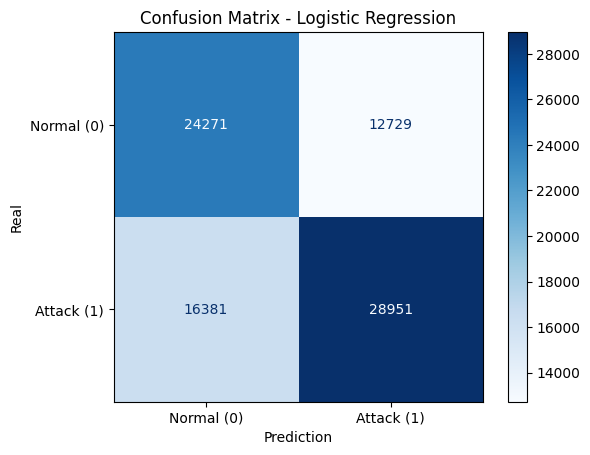

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_preds = {
    "Logistic Regression": y_pred_lr,
}

for name, y_pred in model_preds.items():
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Attack (1)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Prediction")
    plt.ylabel("Real")
    plt.show()

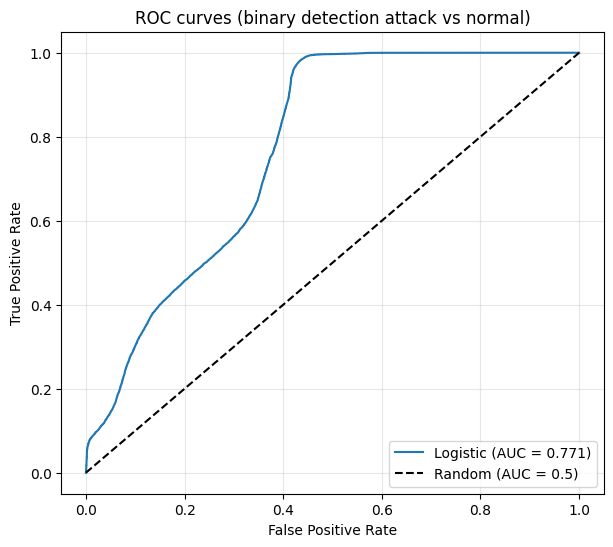

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(7, 6))

# Logistic
y_score_lr = lr.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
auc_lr = roc_auc_score(y_test, y_score_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC = {auc_lr:.3f})")

# Diagonal azar
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (binary detection attack vs normal)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [10]:
import joblib

joblib.dump(X_train_scaled, '../processed/X_train_scaled.pkl')
joblib.dump(X_test_scaled, '../processed/X_test_scaled.pkl')
joblib.dump(y_train, '../processed/y_train.pkl')
joblib.dump(y_test, '../processed/y_test.pkl')
joblib.dump(scaler, '../processed/scaler.pkl')
joblib.dump(le_dict, '../processed/le_dict.pkl')

['../processed/le_dict.pkl']